In [11]:
import sys
import os
import tensorflow as tf

# Aggiunge la cartella src al path per poter importare i moduli
sys.path.append(os.path.abspath("src"))

# Autoreload per ricaricare i moduli se li modifichi durante lo sviluppo
%load_ext autoreload
%autoreload 2

# Import dei tuoi moduli custom
from data_loader import QuantumDataManager
from quantum_transformer import QuantumTransformer
from curriculum import CurriculumLearning
from utils import ExperimentManager 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
TRANSFORMER_CONFIGS = [
    {
        "name": "transformer_small",
        "window_size": 20,
        "forecast_horizon": 20,
        "embed_dim": 64,
        "num_heads": 4,
        "ff_dim": 192,
        "num_layers": 2,
        "dropout": 0.1,
        "learning_rate": 0.0005,
        "batch_size": 64,
        "total_epochs": 23,
        "tf_epochs": 5,
        "mm_epochs": 8,
        "nr_epochs": 10
    },
    {
        "name": "transformer_medium",
        "window_size": 15,
        "forecast_horizon": 15,
        "embed_dim": 64,
        "num_heads": 8,
        "ff_dim": 256,
        "num_layers": 2,          
        "dropout": 0.15,
        "learning_rate": 0.0003,
        "batch_size": 64,
        "total_epochs": 30,
        "tf_epochs": 8,
        "mm_epochs": 5,
        "nr_epochs": 17
    },
    {
        "name": "transformer_large",
        "window_size": 15,
        "forecast_horizon": 1,
        "embed_dim": 64,
        "num_heads": 4,
        "ff_dim": 256,
        "num_layers": 2,
        "dropout": 0.2,
        "learning_rate": 0.0005,
        "batch_size": 64,
        "total_epochs": 12,
        "tf_epochs": 5,
        "mm_epochs": 5,
        "nr_epochs": 2
    }
]

In [ ]:
def progressive_value(step_in_phase, phase_epochs, start_value, end_value):
    denom = max(1, phase_epochs - 1)
    progress = step_in_phase / denom

    return start_value + (end_value - start_value) * progress

def train_with_curriculum(
    model,
    train_ds,
    val_ds,
    optimizer,
    loss_fn,
    epochs,
    tf_epochs,
    mm_epochs,
    nr_epochs
):
    curriculum = CurriculumLearning(model, optimizer, loss_fn)

    history = {
        "loss": [],
        "val_loss": [],
        "phase": []
    }
    
    # Sanity Check
    total_epochs_calc = tf_epochs + mm_epochs + nr_epochs
    assert total_epochs_calc == epochs, (
        f"Errore: epoche totali ({epochs}) != somma fasi ({total_epochs_calc})"
    )
    
    # Parametri Rumore
    NOISE_START = 0.01 
    NOISE_END = 0.20  

    # Parametri Masking
    MASK_START = 0.05
    MASK_END = 0.25 

    for epoch in range(epochs):
        current_std = 0.0

        # --- 1. Determina la fase ---
        if epoch < tf_epochs:
            phase = "teacher_forcing"
        elif epoch < tf_epochs + mm_epochs:
            phase = "masked_modeling"
            current_mask_prob = progressive_value(epoch - tf_epochs, mm_epochs, MASK_START, MASK_END)
        else:
            phase = "noise_teacher_forcing"
            current_std = progressive_value(epoch - (tf_epochs + mm_epochs), nr_epochs, NOISE_START, NOISE_END)

        # --- 2. Training Loop ---
        epoch_loss = tf.keras.metrics.Mean()
        
        print(f"Epoch {epoch+1}/{epochs} [{phase}]", end="")
        if phase == "noise_teacher_forcing":
            print(f" [Noise STD: {current_std:.4f}]", end="")
        print("...")

        for x, y in train_ds:
            if phase == "teacher_forcing":
                loss = curriculum.teacher_forcing_step(x, y)
                
            elif phase == "masked_modeling":
                loss = curriculum.masked_modeling_step(x, y, mask_prob=current_mask_prob)
                
            elif phase == "noise_teacher_forcing": 
                loss = curriculum.noisy_teacher_forcing_step(x, y, noise_std=current_std)
            
            epoch_loss.update_state(loss)

        # --- 3. Validation Loop ---
        val_loss_metric = tf.keras.metrics.Mean()
        for x_val, y_val in val_ds:
            preds = model(
                encoder_input=x_val, 
                decoder_input=y_val, 
                training=False,
                return_attention=False 
            )
            v_loss = loss_fn(y_val, preds)
            val_loss_metric.update_state(v_loss)

        # --- 4. Logging ---
        train_l = epoch_loss.result().numpy()
        val_l = val_loss_metric.result().numpy()
        
        history["loss"].append(train_l)
        history["val_loss"].append(val_l)
        history["phase"].append(phase)

        print(f" -> Train Loss: {train_l:.5f} | Val Loss: {val_l:.5f}")

    return history


--- Avvio Esperimento: transformer_medium ---
Dataset caricato: (250000, 56)
Traiettorie individuate: 250
[transformer_medium] Dataset caricato. Train shape: (194150, 15, 55)
Dati caricati. Input features: 55
Epoch 1/30 [teacher_forcing]...


c:\Users\aldog\miniconda3\envs\DeepProject\Lib\site-packages\keras\src\layers\layer.py:424: UserWarning: `build()` was called on layer 'quantum_transformer_4', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


 -> Train Loss: 0.01502 | Val Loss: 0.00414
Epoch 2/30 [teacher_forcing]...
 -> Train Loss: 0.00155 | Val Loss: 0.00143
Epoch 3/30 [teacher_forcing]...
 -> Train Loss: 0.00059 | Val Loss: 0.00064
Epoch 4/30 [teacher_forcing]...
 -> Train Loss: 0.00031 | Val Loss: 0.00042
Epoch 5/30 [teacher_forcing]...
 -> Train Loss: 0.00021 | Val Loss: 0.00035
Epoch 6/30 [teacher_forcing]...
 -> Train Loss: 0.00015 | Val Loss: 0.00035
Epoch 7/30 [teacher_forcing]...
 -> Train Loss: 0.00012 | Val Loss: 0.00035
Epoch 8/30 [teacher_forcing]...
 -> Train Loss: 0.00010 | Val Loss: 0.00035
Epoch 9/30 [masked_modeling]...
 -> Train Loss: 0.00097 | Val Loss: 0.00147
Epoch 10/30 [masked_modeling]...
 -> Train Loss: 0.00071 | Val Loss: 0.00128
Epoch 11/30 [masked_modeling]...
 -> Train Loss: 0.00062 | Val Loss: 0.00113
Epoch 12/30 [masked_modeling]...
 -> Train Loss: 0.00054 | Val Loss: 0.00099
Epoch 13/30 [masked_modeling]...
 -> Train Loss: 0.00047 | Val Loss: 0.00086
Epoch 14/30 [noise_teacher_forcing] [Noi

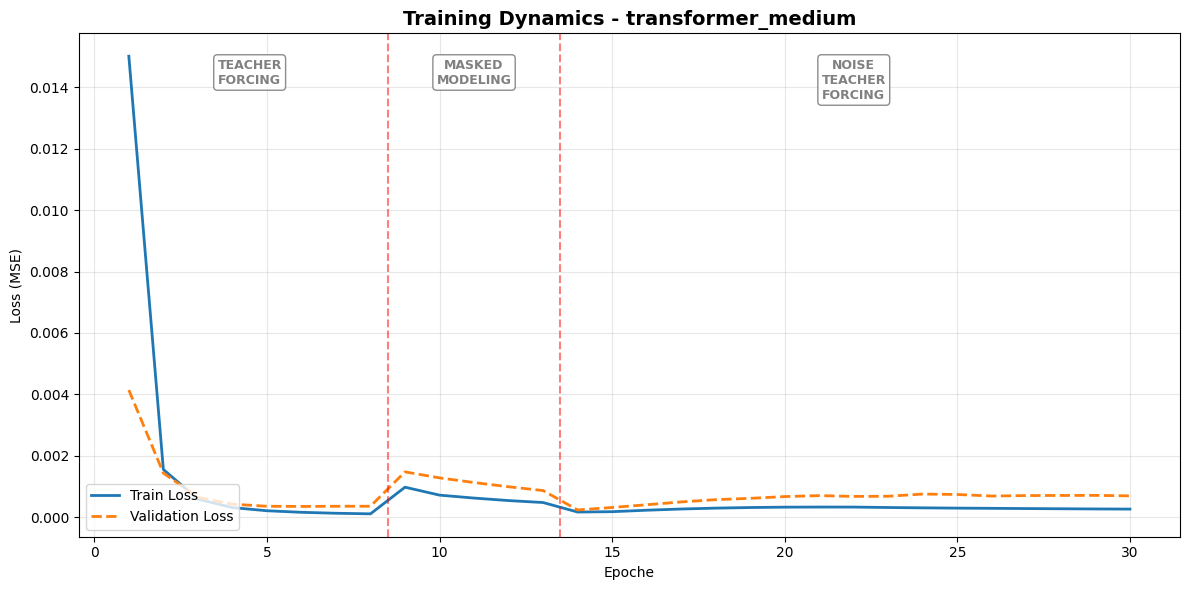

Grafico salvato in: data\plots\training/loss_transformer_medium.png
Generazione predizioni per 1000 step...


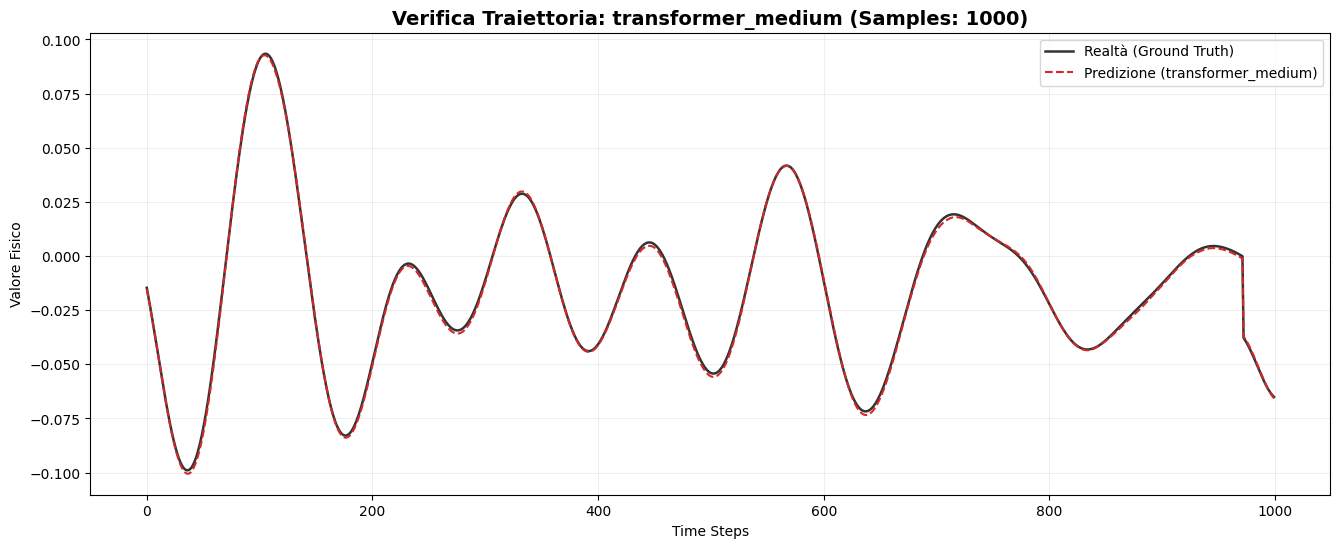

Grafico salvato in: data\plots\predictions/pred_transformer_medium.png
Recupero mappe di attenzione...


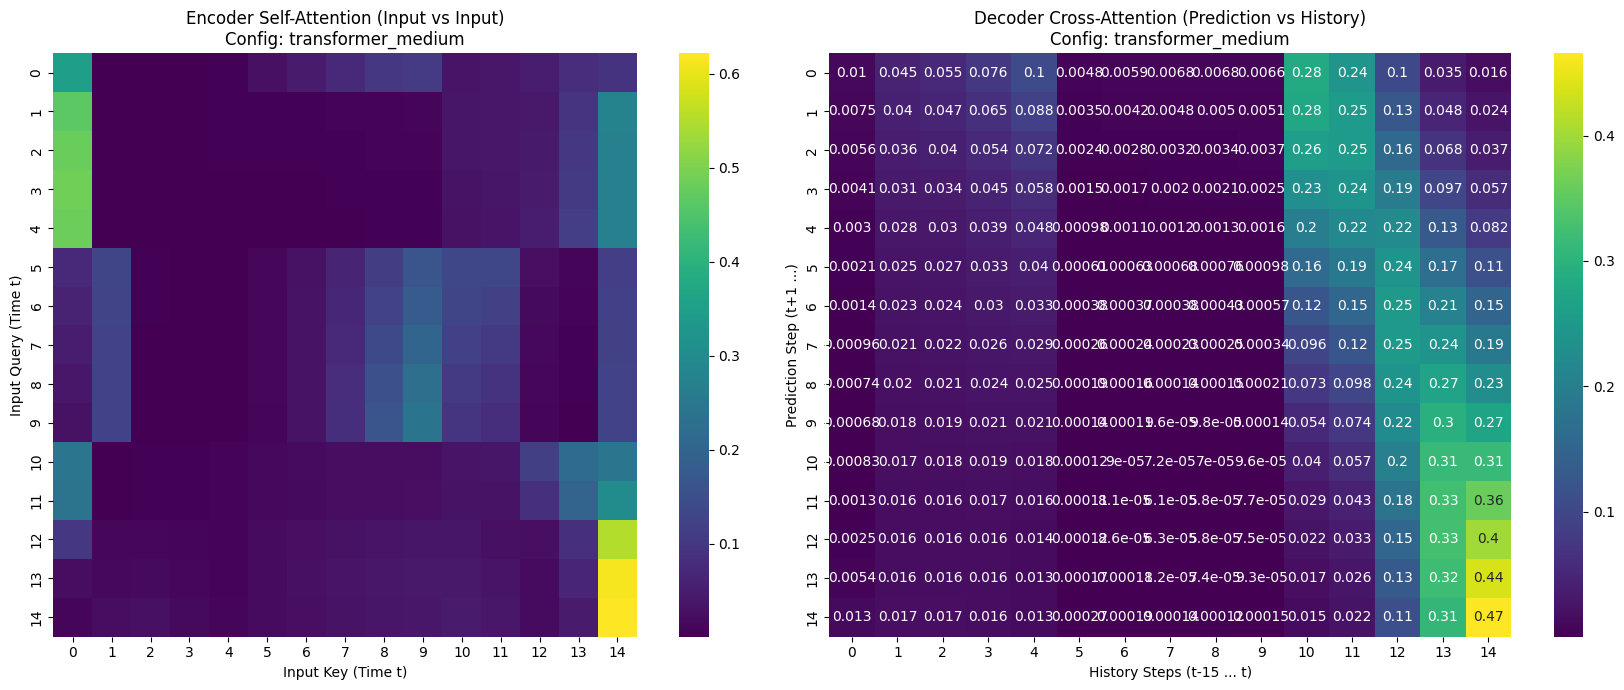

Grafico combinato salvato in: data\plots\attentions/att_transformer_medium.png


(<QuantumTransformer name=quantum_transformer_4, built=True>,
 {'loss': [np.float32(0.0150182415),
   np.float32(0.0015518698),
   np.float32(0.0005855406),
   np.float32(0.00030903087),
   np.float32(0.00020569406),
   np.float32(0.00015497065),
   np.float32(0.00012398693),
   np.float32(0.00010497842),
   np.float32(0.00097342),
   np.float32(0.0007146637),
   np.float32(0.0006188699),
   np.float32(0.0005373854),
   np.float32(0.00047361356),
   np.float32(0.00016377815),
   np.float32(0.00017520638),
   np.float32(0.00022307376),
   np.float32(0.0002624003),
   np.float32(0.00029137242),
   np.float32(0.00031088214),
   np.float32(0.00032272108),
   np.float32(0.00032626445),
   np.float32(0.00032553307),
   np.float32(0.0003114302),
   np.float32(0.0003002037),
   np.float32(0.00029127568),
   np.float32(0.00028456596),
   np.float32(0.00027683258),
   np.float32(0.00027049787),
   np.float32(0.00026427332),
   np.float32(0.0002595888)],
  'val_loss': [np.float32(0.0041401694),
 

In [15]:
exp_manager = ExperimentManager(base_path="data")

def run_curriculum_experiment(config):
    print(f"\n--- Avvio Esperimento: {config['name']} ---")
    
    # 1. Caricamento Dati
    dm = QuantumDataManager(config)
    
    if not hasattr(dm, 'X_train'):
        dm.load_and_process(num_rows=250000)

    input_dim = dm.X_train.shape[-1] 
    train_ds, val_ds = dm.get_tf_datasets()
    
    print(f"Dati caricati. Input features: {input_dim}")

    # 2. Modello
    model = QuantumTransformer(
        input_dim=input_dim,
        seq_len=config['window_size'],
        d_model=config['embed_dim'],
        num_heads=config['num_heads'],
        d_ff=config['ff_dim'],
        num_layers=config['num_layers'],
        dropout=config['dropout']
    )

    optimizer = tf.keras.optimizers.Adam(learning_rate=config['learning_rate'])
    loss_fn = tf.keras.losses.MeanSquaredError()
    
    history = train_with_curriculum(
        model=model,
        train_ds=train_ds,
        val_ds=val_ds,
        optimizer=optimizer,
        loss_fn=loss_fn,
        epochs=config['total_epochs'],
        tf_epochs=config['tf_epochs'],
        mm_epochs=config['mm_epochs'],
        nr_epochs=config['nr_epochs']
    )
    
    # 4. Salvataggio e Plotting
    print("\n--- Salvataggio Risultati ---")
    exp_manager.save_model_artifacts(model, history, config['name'])
    
    print("\n--- Generazione Grafici ---")
    exp_manager.plot_training_phases_detailed(history, config['name'])
    exp_manager.plot_trajectory_check(model, dm, config['name'])
    exp_manager.plot_attention_map(model, dm, config['name'])
    
    return model, history

run_curriculum_experiment(TRANSFORMER_CONFIGS[1])

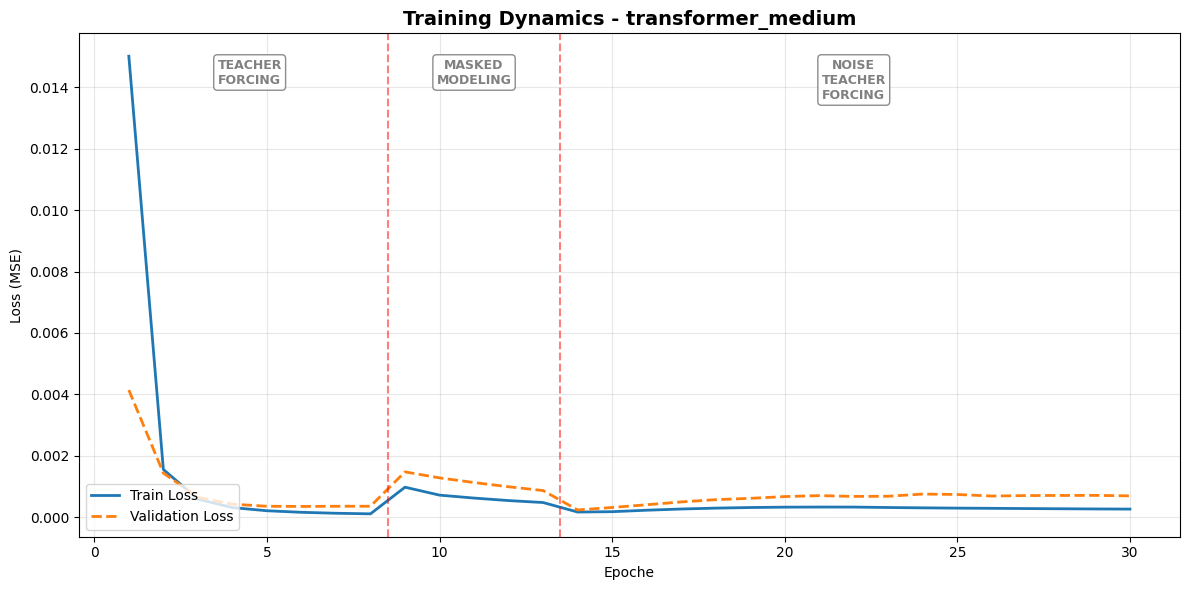

Grafico salvato in: data\plots\training/loss_transformer_medium.png
Dataset caricato: (400400, 56)
Traiettorie individuate: 400
[transformer_medium] Dataset caricato. Train shape: (311040, 15, 55)
Trovato file pesi: data\weights\transformer_medium.weights.h5
Inizializzazione pesi (Dummy Call)...


c:\Users\aldog\miniconda3\envs\DeepProject\Lib\site-packages\keras\src\layers\layer.py:424: UserWarning: `build()` was called on layer 'quantum_transformer_6', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Pesi caricati correttamente.
Generazione predizioni per 1000 step...


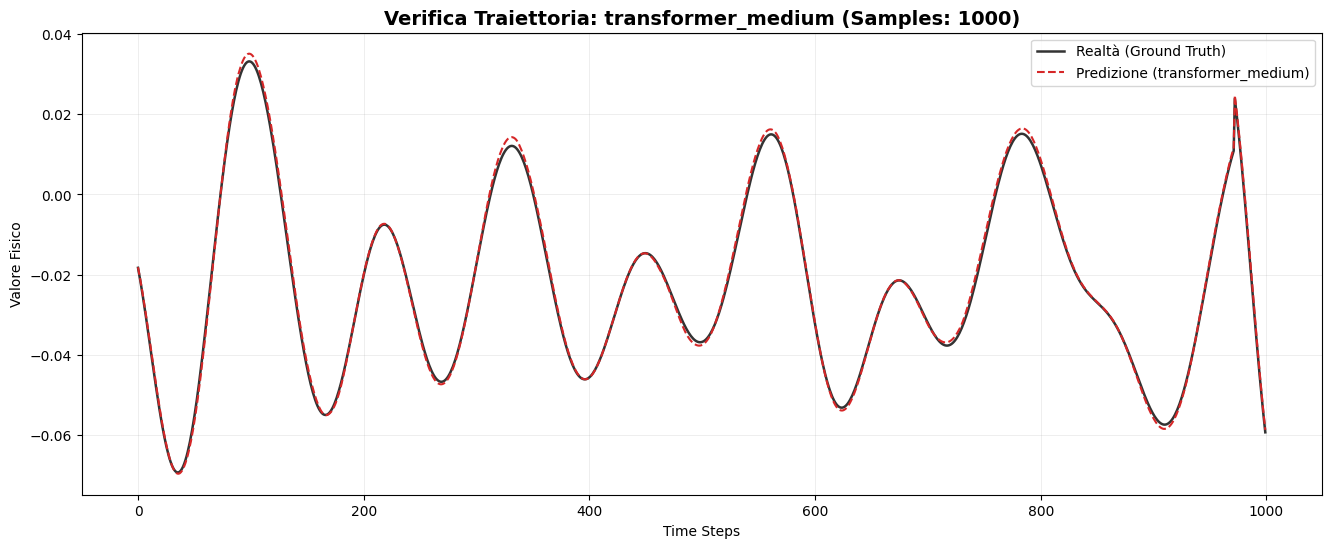

Grafico salvato in: data\plots\predictions/pred_transformer_medium.png
Recupero mappe di attenzione...


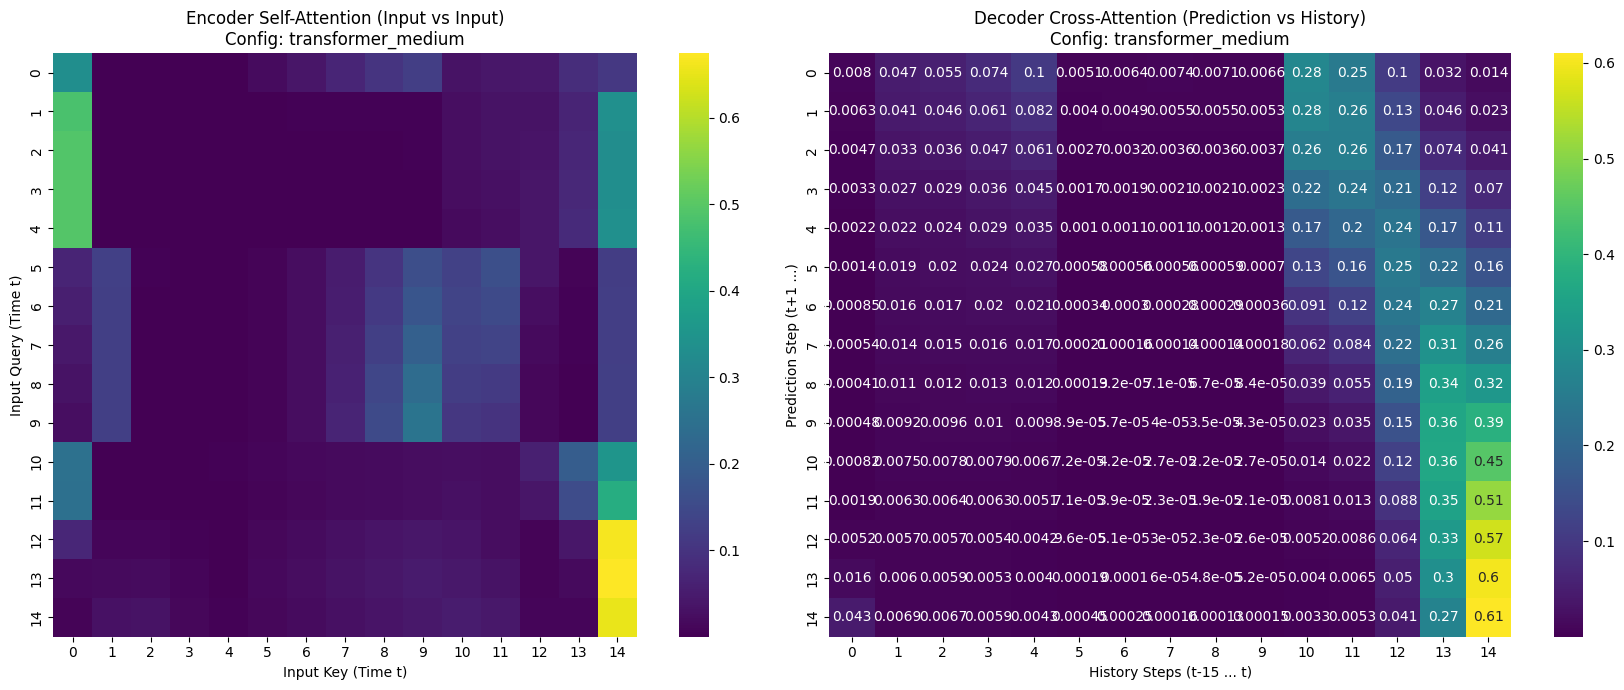

Grafico combinato salvato in: data\plots\attentions/att_transformer_medium.png


In [17]:
import pandas as pd

# 1. Configurazione
config = TRANSFORMER_CONFIGS[1]
exp_manager = ExperimentManager()

# 2. Carica History
history_df = pd.read_csv(f"data/history/{config['name']}_history.csv")
# Converti in dict per la funzione plot
history_dict = history_df.to_dict(orient='list')

# 3. Plot History
exp_manager.plot_training_phases_detailed(history_dict, config['name'])

# 4. Inizializza Data Manager e Modello (necessari per la traiettoria)
dm = QuantumDataManager(config)
dm.load_and_process() # Carica i dati per avere X_test e lo scaler
input_dim = dm.X_train.shape[-1]

model = QuantumTransformer(
    input_dim=input_dim,
    seq_len=config['window_size'],
    d_model=config['embed_dim'],
    num_heads=config['num_heads'],
    d_ff=config['ff_dim'],
    num_layers=config['num_layers'],
    dropout=config['dropout']
)

# 5. Carica Pesi
exp_manager.load_model_weights(model, config['name'])

# 6. Plot Traiettoria
exp_manager.plot_trajectory_check(model, dm, config['name'])

# 7. Plot Attention Map
exp_manager.plot_attention_map(model, dm, config['name'])